# MNIST- handwritten digit recognition
[The MNIST problem](http://yann.lecun.com/exdb/mnist/) is a dataset developed by Yann LeCun, Corinna Cortes and Christopher
Burges for evaluating machine learning models on the handwritten digit classification problem.
The dataset was constructed from a number of scanned document datasets available from the
National Institute of Standards and Technology (NIST). This is where the name for the dataset
comes from, as the Modified NIST or MNIST dataset.
Images of digits were taken from a variety of scanned documents, normalized in size and
centered. This makes it an excellent dataset for evaluating models, allowing the developer to
focus on the machine learning with very little data cleaning or preparation required. Each
image is a 28 × 28 pixel square (784 pixels total).
The dataset below has 60000 images for training and 10000 for testing. Labels are the 10 digits (0-9), therefore it is a multi-class classification problem. Excellent results achieve a prediction error of less than 1%. State-of-the-art prediction
error of approximately 0.2% can be achieved with large Convolutional Neural Networks.

## Loading Data & EDA

In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using TensorFlow backend.


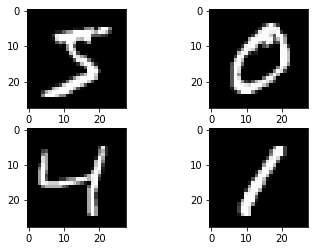

In [2]:
# fix random seed for reproducibility
seed = 123
np.random.seed(seed)
# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap='gray')
plt.subplot(222)
plt.imshow(X_train[1], cmap='gray') 
plt.subplot(223)
plt.imshow(X_train[2], cmap='gray')
plt.subplot(224)
plt.imshow(X_train[3], cmap='gray')
# show the plot
plt.show()

In [3]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train.max(), X_train.min()) # Note that the pixel value scales 0-255 

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
255 0


## Baseline model using simple neural net
MNIST problem is not terribly difficult that we may get a decent result by using simple neural nets without CNN. We can build a baseline model with a simple neural net and later compare how a CNN model does better that the baseline.

A simple NN talkes 1D input, so we will change the data shape to a 1D vector: a 2D image of 28x28 pixels is reshaped (flattened) to a 1D vector of 784 pixels. Then the pixel values are normalized so that a value is between 0 and 1. Then we make labels (both y_train and y_test) to categorical- which means we make 10 columns with values 0 or 1 instead of 1 column with values 0-9.     


In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import keras.utils as np_utils

# fix random seed for reproducibility
seed = 123
np.random.seed(seed)
# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

# define baseline model
def baseline_model():
### YOUR TURN: 
#   Build a model using Sequential() which has 1 Dense hidden layer and 1 output    
#   For the dense layer, give the number of neurons the same as the number of the input pixels 
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
#   Compile model
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    return model
# build the model
model = baseline_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 4s - loss: 0.2784 - accuracy: 0.9211 - val_loss: 0.1332 - val_accuracy: 0.9625
Epoch 2/20
 - 4s - loss: 0.1105 - accuracy: 0.9679 - val_loss: 0.1002 - val_accuracy: 0.9687
Epoch 3/20
 - 3s - loss: 0.0714 - accuracy: 0.9794 - val_loss: 0.0788 - val_accuracy: 0.9755
Epoch 4/20
 - 4s - loss: 0.0513 - accuracy: 0.9852 - val_loss: 0.0687 - val_accuracy: 0.9784
Epoch 5/20
 - 3s - loss: 0.0370 - accuracy: 0.9896 - val_loss: 0.0631 - val_accuracy: 0.9800
Epoch 6/20
 - 4s - loss: 0.0274 - accuracy: 0.9927 - val_loss: 0.0603 - val_accuracy: 0.9803
Epoch 7/20
 - 4s - loss: 0.0200 - accuracy: 0.9944 - val_loss: 0.0648 - val_accuracy: 0.9791
Epoch 8/20
 - 3s - loss: 0.0150 - accuracy: 0.9965 - val_loss: 0.0640 - val_accuracy: 0.9810
Epoch 9/20
 - 3s - loss: 0.0112 - accuracy: 0.9977 - val_loss: 0.0579 - val_accuracy: 0.9823
Epoch 10/20
 - 4s - loss: 0.0085 - accuracy: 0.9984 - val_loss: 0.0598 - val_accuracy: 0.9816
Epoch 11/20
 - 4s -

## Simple CNN model
Now we will build a simple CNN model and see if it can do better than our baseline model above (NN without convolution layer).

In [5]:
# Simple CNN for the MNIST Dataset
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import keras.utils as np_utils
from keras import backend as K

# fix random seed for reproducibility
seed = 123
numpy.random.seed(seed)
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#### YOUR TURN
# Reshape X_train and X_test to be (n_samples, width, height, channels)
# Then cast the data type of the arrays to type 'float32'
# Hint: the n_channel is 1 in this case. You can use .shape
# Hint: .astype() changes numpy array's data type
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype( 'float32' )
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype( 'float32' ) 

### YOUR TURN
# Normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# Encode labels to categorical
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

# define a simple CNN model
def simple_cnn_model(dropout=False):
    # create model
### YOUR TURN
# Build a model that has 1 convolution layer, 1 max pooling, 1 dense, and output 
# Use 32 filters with 5x5 size
# For max pooling layer, make the layer such that the featuremap size would be the half after the pooling layer
# hint: you need to change the argument input_shape to (w,h,1) in the first conv layer
# hint: you need Flatten() befor the first dense layer
    model = Sequential()
    model.add(Conv2D(32, 5, 5, input_shape=(28, 28, 1), activation= 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if dropout: # you can turn off drop out if you set dropout=False. try yourself if they make any difference 
        model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation= 'relu'))
    model.add(Dense(num_classes, activation= 'softmax'))
    
# Compile the model using the same options as above
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    return model

# build the model
model = simple_cnn_model()

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, verbose=1)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

C:\Users\libphy\AppData\Local\Continuum\anaconda3\envs\sk22tf2\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), input_shape=(28, 28, 1..., activation="relu")`


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 16s 265us/step - loss: 0.2325 - accuracy: 0.9335 - val_loss: 0.0691 - val_accuracy: 0.9795
Epoch 2/20
60000/60000 [==============================] - 17s 284us/step - loss: 0.0671 - accuracy: 0.9805 - val_loss: 0.0502 - val_accuracy: 0.9825
Epoch 3/20
60000/60000 [==============================] - 17s 286us/step - loss: 0.0476 - accuracy: 0.9859 - val_loss: 0.0411 - val_accuracy: 0.9867
Epoch 4/20
60000/60000 [==============================] - 18s 295us/step - loss: 0.0352 - accuracy: 0.9893 - val_loss: 0.0380 - val_accuracy: 0.9864
Epoch 5/20
60000/60000 [==============================] - 17s 291us/step - loss: 0.0283 - accuracy: 0.9914 - val_loss: 0.0395 - val_accuracy: 0.9874
Epoch 6/20
60000/60000 [==============================] - 18s 294us/step - loss: 0.0225 - accuracy: 0.9934 - val_loss: 0.0338 - val_accuracy: 0.9886
Epoch 7/20
60000/60000 [==============================] 

With this model, the error is about 1%

## Two-layer CNN model
Let's stack another convolutional layer.

In [ ]:
# YOUR TURN
# Build a 2-conv layer model
# Try this architecture: conv-maxpool-conv-maxpool-dense-dense-output
# Use 32 (5x5) filters for the first conv layer, and use 16 (3x3) filters for the second conv layer
# Use the same max pool as above
# (optional) you can compare with and with out dropout layer after the second maxpool layer
# Usng dropout is a way to regularize your model. Dropout randomly drops some neurons in the feature map.
# By dropping out some units, it effectively makes the model smaller so it helps reducing the overfitting. 
# see https://keras.io/layers/core/#dropout for the use
# Use 1-2 dense layers before the output
def bilayer_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, 5, input_shape=(28, 28, 1), activation= 'relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, 3, activation= 'relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation= 'relu' ))
    model.add(Dense(50, activation= 'relu' ))
    model.add(Dense(num_classes, activation= 'softmax' ))
    # Compile model using the same options
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    return model
    
# build the model
model = bilayer_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200,
verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

With this model, you might get errors between high 60% to low 80%.

## More convolution layers 

In [8]:
def multilayer_cnn_model():
    # create model
    model = Sequential()
## YOUR TURN
# Build a model with 4 convolutional layers
# choose your own hyperparameters for conv layers
# choose to include maxpool if you like 
# choose to include dropout if you like
    model = Sequential()
    model.add(Conv2D(16, (3, 3), input_shape=(28, 28, 1), activation= 'relu', padding='same')) #I just added padding option for fun, but it's not necessary here.
    model.add(Conv2D(16, (3, 3), activation= 'relu', padding='valid')) #in Keras 2, kernel size or filter size can be integer or tuple
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation= 'relu', padding='same'))
    model.add(Conv2D(32, (3, 3), activation= 'relu', padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation= 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation= 'relu'))
    model.add(Dense(num_classes, activation= 'softmax'))
    # Compile model
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    return model

# build the model
model = multilayer_cnn_model()

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200,
verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 40s - loss: 0.4281 - accuracy: 0.8589 - val_loss: 0.0677 - val_accuracy: 0.9774
Epoch 2/20
 - 43s - loss: 0.1258 - accuracy: 0.9624 - val_loss: 0.0472 - val_accuracy: 0.9840
Epoch 3/20
 - 46s - loss: 0.0938 - accuracy: 0.9712 - val_loss: 0.0371 - val_accuracy: 0.9878
Epoch 4/20
 - 51s - loss: 0.0757 - accuracy: 0.9774 - val_loss: 0.0297 - val_accuracy: 0.9897
Epoch 5/20
 - 53s - loss: 0.0661 - accuracy: 0.9797 - val_loss: 0.0241 - val_accuracy: 0.9922
Epoch 6/20


KeyboardInterrupt: 

This model's error is about 0.5x-0.6x %

Discussion:
Give bullet pints summary of what you have found from above experiments.
e.g. 
- how is a 1-layer ANN vs. 1-layer CNN?
- when the number of layers increases, what happens to the performance?
- what happens if I have very deep CNN? did you face with any problems?
- what can you do to reduce an overfitting problem?
- search internet and list other ways to reduce overfitting in CNN

In [ ]:
def unit(model, n_filter=16, init=False, dropout=True):
    if init:
        model.add(Conv2D(16,3,input_shape=(28,28,1),activation='relu',padding='same')) #I used the same padding to be safe as the layers gets deeper.
        model.add(Conv2D(16,3,activation='relu',padding='same'))
    else:   
        model.add(Conv2D(n_filter,3,activation='relu',padding='same'))
        model.add(Conv2D(n_filter,3,activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if dropout:
        model.add(Dropout(0.2))
    return model
    
def deep_cnn_model(n, dropout=True):
    """
    n: repeated number of basic unit
    let's say the basic unit is conv(3x3)-conv(3x3)-maxpool-dropout(0.2)
    """
    model=Sequential()
    model = unit(model,init=True,dropout=dropout)
    if n>1:
        for i in range(1, n):
            filters = min(16*2**i,512) #limit the number of filters for the resource purpose
            model=unit(model,n_filter=filters)       
    model.add(Flatten())
    model.add(Dense(64, activation= 'relu'))
    model.add(Dense(num_classes, activation= 'softmax'))  
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    return model

In [ ]:
# build the model
model = deep_cnn_model(4)
model.summary()

In [ ]:
# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=200,
verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
plt.plot(history.history['acc'],'b') #train acc
plt.plot(history.history['val_acc'],'g') #val acc

In [ ]:
# let's compare if we don't have dropout
model = deep_cnn_model(4,dropout=False)
# Fit the model
history2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=200,
verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
plt.plot(history.history['acc'],'b') #train acc
plt.plot(history.history['val_acc'],'g') #val acc

conclusion: dropout didn't do much here. And it seems that the overfitting is not happening within the epoch.
It seems that the model size is just right. But the effectiveness of having 8 conv layers versus 3 layers seems to be questionable.